# Developing scripts for skill assessment

In [1]:
import cartopy
import cartopy.crs as ccrs

cartopy.config["pre_existing_data_dir"] = "../../data/cartopy-data"
cartopy.config["data_dir"] = "../../data/cartopy-data"

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

from src.verify import verify

/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [3]:
xr.set_options(keep_attrs=True)

In [10]:
from dask.distributed import Client
from dask_jobqueue import PBSCluster

walltime = "02:00:00"
cores = 12
memory = "48GB"
cluster = PBSCluster(
    walltime=str(walltime),
    cores=cores,
    memory=str(memory),
    job_extra=[
        "-l ncpus=" + str(cores),
        "-l mem=" + str(memory),
        "-P xv83",
        "-l jobfs=100GB",
        "-l storage=gdata/xv83",
    ],
    local_directory="$PBS_JOBFS",
    # env_extra=['export MALLOC_TRIM_THRESHOLD_="0"'],
    header_skip=["select"],
)

cluster.scale(jobs=4)
client = Client(cluster)
client

/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.6.73.36:8787/status,
Dashboard: http://10.6.73.36:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.73.36:35699,Workers: 0
Dashboard: http://10.6.73.36:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Load some data

In [4]:
DATA_DIR = "../../data/processed/"

hcst = xr.open_zarr(f"{DATA_DIR}/CAFEf6.annual.anom_1991-2020.sst.zarr")
hist = xr.open_zarr(f"{DATA_DIR}/CAFE_hist.annual.anom_1991-2020.sst.zarr")
obsv = xr.open_zarr(f"{DATA_DIR}/HadISST.annual.anom_1991-2020.sst.zarr")

In [45]:
import xskillscore as xs


def acc(hcst, obsv):
    """
    Return the anomaly cross correlation between two timeseries

    Parameters
    ----------
    hcst : xarray Dataset
        The forecast timeseries
    obsv : xarray Dataset
        The observed timeseries
    """
    return xs.pearson_r(hcst.mean("member"), obsv, dim="time")

In [881]:
def acc_initialised(hcst, obsv, hist):
    """
    Return the initialised component of anomaly cross correlation between
    a forecast and observations

    Parameters
    ----------
    hcst : xarray Dataset
        The forecast timeseries
    obsv : xarray Dataset
        The observed timeseries
    hist : xarray Dataset
        The historical simulation timeseries
    """
    rXY = xs.pearson_r(hcst, obsv, dim="time")
    rXU = xs.pearson_r(obsv, hist, dim="time")
    rYU = xs.pearson_r(hcst, hist, dim="time")
    θ = xr.where(rYU < 0, 0, 1, keep_attrs=False)
    ru = θ * rXU * rYU
    return rXY - ru

In [882]:
def msss(hcst, obsv, ref):
    """
    Return the mean spared skill score between a forecast and observations

    Parameters
    ----------
    hcst : xarray Dataset
        The forecast timeseries
    obsv : xarray Dataset
        The observed timeseries
    ref : xarray Dataset
        The reference timeseries
    """
    num = xs.mse(hcst, obsv, dim="time")
    den = xs.mse(ref, obsv, dim="time")
    return 1 - num / den

In [69]:
N_BOOTSTRAP_ITERATIONS = 10

In [76]:
def calculate_metric_from_timeseries(*timeseries, metric):
    sample_metric = metric(*timeseries)

    #     @dask.delayed
    def _delayed_bootstrapped_metric(*timeseries, metric):
        return metric(*bootstrap(*timeseries, dim=["time", "member"]))

    bootstrap_tasks = [
        _delayed_bootstrapped_metric(*timeseries, metric=metric)
        for _ in range(N_BOOTSTRAP_ITERATIONS)
    ]
    datasets = dask.compute(bootstrap_tasks)

    return sample_metric

In [77]:
import dask


def calculate_metric(hindcast, *references, metric, metric_kwargs={}):
    """
    Calculate a skill metric for a set of hindcasts over a common set of
    verification dates at all leads

    Parameters
    ----------
    hindcast : xarray Dataset
        The hindcast data to verify. Must have "init" and "lead" dimensions
    references : xarray Dataset(s)
        The data to verify against. Multiple datasets can be provided for skill
        metrics that require it, e.g. metrics that use both the observations
        and the historical simulations
    metric : function
        The metric to apply. Will first look for function in src.verify then
        in xskillscore
    metric_kwargs : dict
        kwargs to pass to the function `metric`
    """

    def _common_set_of_verif_times(hcst, *refs):
        """Get the common set of verification times available at all leads"""
        hcst_times = hcst.time.compute()
        if len(refs) > 1:
            valid_times = xr.align(*[ref.time for ref in refs])[0].values
        else:
            valid_times = refs[0].time.values
        times = [i for i in valid_times if (i == hcst_times).any("init").all("lead")]
        if not times:
            raise ValueError(
                "I could not find a common set of verification dates at all leads"
            )
        return times

    verif_times = _common_set_of_verif_times(hindcast, *references)
    references_verif_times = [ref.sel(time=verif_times) for ref in references]

    # Loop over leads and calculate metric
    results = []
    for lead in hindcast["lead"]:
        hindcast_verif_times = (
            hindcast.sel(lead=lead).swap_dims({"init": "time"}).sel(time=verif_times)
        )
        results.append(
            calculate_metric_from_timeseries(
                hindcast_verif_times,
                *references_verif_times,
                metric=metric,
                **metric_kwargs
            )
        )
    return xr.concat(results, dim="lead")

In [78]:
%%time
calculate_metric(hcst, obsv, metric=acc)

CPU times: user 35.7 s, sys: 2.03 s, total: 37.7 s
Wall time: 52.1 s


<xarray.Dataset>
Dimensions:     (lead: 10, lat: 90, lon: 144)
Coordinates:
    average_DT  timedelta64[ns] 31 days
    average_T1  (lead) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2  (lead) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * lat         (lat) float64 -89.49 -87.98 -85.96 -83.93 ... 85.96 87.98 89.49
  * lead        (lead) int64 11 23 35 47 59 71 83 95 107 119
  * lon         (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
    zsurf       (lat, lon) float32 2.83e+03 2.83e+03 2.83e+03 ... 0.0 0.0 0.0
    area        (lat, lon) float32 2.758e+08 2.758e+08 ... 2.758e+08 2.758e+08
Data variables:
    sst         (lead, lat, lon) float64 dask.array<chunksize=(1, 45, 72), meta=np.ndarray>

In [843]:
can_msss = calculate_metric(hcst.mean("member"), obsv, hist.mean("member"), metric=msss)

ValueError: indexes along dimension 'time' are not equal

In [92]:
can_ri = calculate_metric(
    hcst.mean("member"), obsv, hist.mean("member"), metric=acc_initialised
)

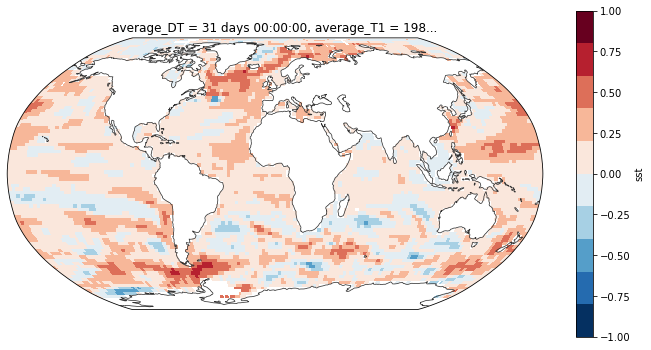

In [457]:
import matplotlib.cm as cm

fig = plt.figure(figsize=(12, 6), edgecolor="k")
ax = fig.add_subplot(111, projection=ccrs.Robinson(0))
cmap = cm.get_cmap("RdBu_r", 10)

p = (
    can_ri["sst"]
    .isel(lead=1)
    .plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-1, vmax=1, cmap=cmap)
)

p.axes.coastlines(color=[0.2, 0.2, 0.2], linewidth=0.75)

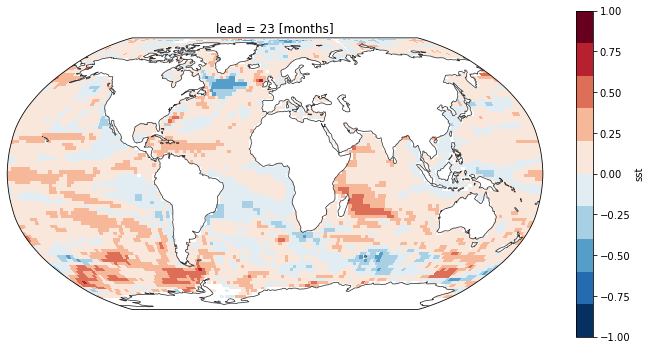

In [447]:
import matplotlib.cm as cm

fig = plt.figure(figsize=(12, 6), edgecolor="k")
ax = fig.add_subplot(111, projection=ccrs.Robinson(0))
cmap = cm.get_cmap("RdBu_r", 10)

p = (
    acc_init["sst"]
    .isel(lead=1)
    .plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-1, vmax=1, cmap=cmap)
)

p.axes.coastlines(color=[0.2, 0.2, 0.2], linewidth=0.75)

# Resampling

In [906]:
def test_nested_random_resample():
    """
    Tests the function nested_random_resample

    For each axis level of nested random sampling this checks that the elements
    outer to the randomly sample axis are the same for each random sample. This
    is only a check that the nesting hasn't not worked
    """

    import itertools

    # Generate some test data with data that makes it location clear
    shape = (6, 5, 4, 3, 2)
    axes = ["a", "b", "c", "d", "e"]
    n_axes = 2
    test = np.zeros(shape, dtype="<U16")
    for i in itertools.product(*[range(i) for i in shape]):
        test[i] = "".join([f"{axes[j]}{i[j]}" for j in range(len(i))])

    # Randomly resample the test data
    nested_indexes = _nested_random_indexes(dict(zip(axes, shape)))
    indexes = _expand_nested_random_indexes([nested_indexes[k] for k in axes])
    res = test[indexes]

    # Check that the nesting hasn't not worked
    for a in range(-n_axes, 0):
        # Look at a random location for the not sampled axes
        idx = [np.random.randint(0, i) for i in res.shape[:a]]
        idx.append(slice(None))

        for element_idx in itertools.product(*[range(i) for i in res.shape[a:][1:]]):
            to_check = res[tuple(idx + list(element_idx))]
            identical_elements = [s[: 2 * (res.ndim + a)] for s in to_check]
            assert len(set(identical_elements)) == 1

In [907]:
test_nested_random_resample()

In [5]:
def _n_nested_random_indexes(sizes, iterations):
    """
    Returns indexes to randomly resample (with replacement) an array in a nested
    manner. I.e. randomly resample the first dimension, then for each randomly
    sampled element along that dimension, randomly resample the second dimension,
    then for each randomly sampled element along that dimension, randomly resample
    the third dimension etc.

    Parameters
    ----------
    sizes : OrderedDict
        Dictionary with the names and sizes of the dimensions to resample
    """

    shape = [s for s in sizes.values()]
    indexes = OrderedDict()
    for ax, key in enumerate(sizes.keys()):
        indexes[key] = np.random.randint(0, shape[ax], shape[: ax + 1] + [iterations])
    return indexes

In [6]:
def _expand_nested_random_indexes(indexes):
    """
    Expand the dimensions of the nested input arrays so that they can be broadcast
    and return a tuple that can be directly indexed

    Parameters
    ----------
    indexes : list of numpy arrays
        List of numpy arrays of sequentially increasing dimension as output by the
        function `nested_random_indexes`
    """
    broadcast_ndim = indexes[-1].ndim
    broadcast_indices = []
    for i, index in enumerate(indexes):
        expand_axes = list(range(i + 1, broadcast_ndim - 1))
        broadcast_indices.append(np.expand_dims(index, axis=expand_axes))
    return (..., *tuple(broadcast_indices))

In [53]:
ds1 = hcst
ds2 = ds1  # .isel(member=0)
dim = ["init", "member"]

In [ ]:
from collections import OrderedDict


def _random_indexes(shape, n_iterations):
    """
    Returns indexes to randomly resample (with replacement) an array in a nested
    manner. I.e. randomly resample the first dimension, then for each randomly
    sampled element along that dimension, randomly resample the second dimension,
    then for each randomly sampled element along that dimension, randomly resample
    the third dimension etc.

    Parameters
    ----------
    sizes : OrderedDict
        Dictionary with the names and sizes of the dimensions to resample
    """
    indexes = []
    for ax in range(len(shape)):
        indexes.append(np.random.randint(0, shape[ax], [shape[ax]] + [n_iterations]))
    return indexes


def _expand_nested_random_indexes(indexes):
    """
    Expand the dimensions of the nested input arrays so that they can be broadcast
    and return a tuple that can be directly indexed

    Parameters
    ----------
    indexes : list of numpy arrays
        List of numpy arrays of sequentially increasing dimension as output by the
        function `nested_random_indexes`
    """
    broadcast_ndim = indexes[-1].ndim
    broadcast_indices = []
    for i, index in enumerate(indexes):
        broadcast_indices.append(
            np.expand_dims(index, axis=list(range(i + 1, broadcast_ndim)))
        )
    return (..., *tuple(broadcast_indices))


def bootstrap(*objects, dim, update_outer_dim_coords=True):
    """
    Bootstrap the provided array across the specified dimension in a nested
    manner. I.e. bootstrap the first provided dimension, then for each
    bootstrapped sample along that dimenion, bootstrap the second provided
    dimension, then for each bootstrapped sample along that dimenion...

    Parameters
    ----------
    objects : iterable of Datasets
        The data to bootstrap. Multiple datasets can be passes to be
        bootstrapped in the same way. Where multiple datasets are passed,
        all datasets need not contain all bootstrapped dimensions. However,
        because of the bootstrapping is applied in a nested manner, the
        dimensions in all input objects must also be nested. E.g., for
        `dim=['d1','d2','d3']` an object with dimensions 'd1' and 'd2' is
        valid but an object with only dimension 'd2' is not.
    dim : str or iterable of str
        The dimension(s) to bootstrap in a nested manner.
    update_outer_dim_coords : boolean, optional
        If True, the index coordinates of the outer (first) dimension in
        dim and any non-index coordinates with this dimension are updated
        to reflect the bootstrap shuffling along that dimension. Otherwise,
        the data are shuffled, but the coordinates are left unchanged.
    """

    def _bootstrap(*arrays, indexes):
        """Bootstrap the array(s) using the provided indexes"""
        n_iterations = indexes[0].shape[-1]

        array = arrays[0]
        index = [list(ind[:, 0]) for ind in indexes]
        print(array)
        multi_index = [range(s) for s in array.shape[: -len(index)]] + index
        raveled_indices = np.ravel_multi_index(tuple(multi_index), array.shape)
        print(raveled_indices)
        #         print(array)
        #         indices = (..., *)
        #         print(indices)
        #         print(array[indices])
        #         test = dask.array.stack(
        #             [array[(..., *[ind[:, 0] for ind in indexes])] for i in range(n_iterations)]
        #         )
        #         print(test)
        return [array[index] for array, index in zip(arrays, indexes)]

    if isinstance(dim, str):
        dim = [dim]

    # Get the sizes of the bootstrap dimensions
    sizes = None
    for obj in objects:
        try:
            sizes = [obj.sizes[d] for d in dim]
            break
        except KeyError:
            pass
    if sizes is None:
        raise ValueError("At least one input object must contain all dimensions in dim")

    # Generate the random indices first so that we can be sure that each
    # dask chunk uses the same indices. Note, I tried using random.seed()
    # to achieve this but it was flaky
    iterations = 10
    indexes = _random_indexes(sizes, iterations)
    input_core_dims = [[d for d in dim if d in obj.dims] for obj in objects]

    results = xr.apply_ufunc(
        _bootstrap,
        *objects,
        kwargs=dict(
            indexes=indexes,
        ),
        input_core_dims=input_core_dims,
        output_core_dims=input_core_dims,
        dask="allowed",
        output_dtypes=[float] * len(input_core_dims),
    )

    def update_outer_dim_coords(ds, outer_dim_indexes):
        coords_to_update = [c for c in ds.coords if (dim[0] in ds[c].dims)]
        for c in coords_to_update:
            new_coord = ds[c].transpose(dim[0], ...)[outer_dim_indexes]
            ds = ds.assign_coords({c: (new_coord.dims, new_coord.values)})
        return ds

    if update_outer_dim_coords:
        if len(objects) == 1:
            return update_outer_dim_coords(results, nested_indexes[dim[0]])
        else:
            return [
                update_outer_dim_coords(result, nested_indexes[dim[0]])
                for result in results
            ]
    else:
        return results

In [27]:
from collections import OrderedDict


def _nested_random_indices(sizes):
    """
    Returns indices to randomly resample (with replacement) an array in a nested
    manner. I.e. randomly resample the first dimension, then for each randomly
    sampled element along that dimension, randomly resample the second dimension,
    then for each randomly sampled element along that dimension, randomly resample
    the third dimension etc.

    Parameters
    ----------
    sizes : OrderedDict
        Dictionary with the names and sizes of the dimensions to resample
    """

    shape = [s for s in sizes.values()]
    indices = OrderedDict()
    for ax, key in enumerate(sizes.keys()):
        indices[key] = np.random.randint(0, shape[ax], shape[: ax + 1])
    return indices


def _expand_nested_random_indices(indices):
    """
    Expand the dimensions of the nested input arrays so that they can be broadcast
    and return a tuple that can be directly indexed

    Parameters
    ----------
    indices : list of numpy arrays
        List of numpy arrays of sequentially increasing dimension as output by the
        function `nested_random_indices`
    """
    broadcast_ndim = indices[-1].ndim
    broadcast_indices = []
    for i, ind in enumerate(indices):
        broadcast_indices.append(
            np.expand_dims(ind, axis=list(range(i + 1, broadcast_ndim)))
        )
    return (..., *tuple(broadcast_indices))


def nested_bootstrap(*objects, dim, update_outer_dim_coords=True):
    """
    Bootstrap the provided array across the specified dimension in a nested
    manner. I.e. bootstrap the first provided dimension, then for each
    bootstrapped sample along that dimenion, bootstrap the second provided
    dimension, then for each bootstrapped sample along that dimenion...

    Parameters
    ----------
    objects : iterable of Datasets
        The data to bootstrap. Multiple datasets can be passes to be
        bootstrapped in the same way. Where multiple datasets are passed,
        all datasets need not contain all bootstrapped dimensions. However,
        because of the bootstrapping is applied in a nested manner, the
        dimensions in all input objects must also be nested. E.g., for
        `dim=['d1','d2','d3']` an object with dimensions 'd1' and 'd2' is
        valid but an object with only dimension 'd2' is not.
    dim : str or iterable of str
        The dimension(s) to bootstrap in a nested manner.
    update_outer_dim_coords : boolean, optional
        If True, the index coordinates of the outer (first) dimension in
        dim and any non-index coordinates with this dimension are updated
        to reflect the bootstrap shuffling along that dimension. Otherwise,
        the data are shuffled, but the coordinates are left unchanged.
    """

    def _bootstrap(*arrays, indices):
        """Bootstrap the array(s) using the provided indices"""
        bootstrapped = [array[ind] for array, ind in zip(arrays, indices)]
        if len(bootstrapped) == 1:
            return bootstrapped[0]
        else:
            return tuple(bootstrapped)

    if isinstance(dim, str):
        dim = [dim]

    # Get the sizes of the bootstrap dimensions
    sizes = None
    for obj in objects:
        try:
            sizes = OrderedDict({d: obj.sizes[d] for d in dim})
            break
        except KeyError:
            pass
    if sizes is None:
        raise ValueError("At least one input object must contain all dimensions in dim")

    # Generate the random indices first so that we can be sure that each
    # dask chunk uses the same indices. Note, I tried using random.seed()
    # to achieve this but it was flaky
    nested_indices = _nested_random_indices(sizes)  # Indices to resample all objects

    # Need to expand the indices for broadcasting for each object separately
    # as each object may have different dimensions
    indices = []
    input_core_dims = []
    for obj in objects:
        available_dims = [d for d in dim if d in obj.dims]
        indices_to_expand = [nested_indices[key] for key in available_dims]

        # Check that dimensions are nested
        ndims = [i.ndim for i in indices_to_expand]
        if ndims != list(range(1, len(ndims) + 1)):
            raise ValueError("The dimensions of all inputs must be nested")

        indices.append(_expand_nested_random_indices(indices_to_expand))
        input_core_dims.append(available_dims)

    results = xr.apply_ufunc(
        _bootstrap,
        *objects,
        kwargs=dict(
            indices=indices,
        ),
        input_core_dims=input_core_dims,
        output_core_dims=input_core_dims,
        dask="parallelized",
        output_dtypes=[float] * len(input_core_dims),
    )

    def _update_outer_dim_coords(ds, outer_dim_indices):
        coords_to_update = [c for c in ds.coords if (dim[0] in ds[c].dims)]
        for c in coords_to_update:
            new_coord = ds[c].transpose(dim[0], ...)[outer_dim_indices]
            ds = ds.assign_coords({c: (new_coord.dims, new_coord.values)})
        return ds

    if update_outer_dim_coords:
        if len(objects) == 1:
            return _update_outer_dim_coords(results, nested_indices[dim[0]])
        else:
            return [
                _update_outer_dim_coords(result, nested_indices[dim[0]])
                for result in results
            ]
    else:
        return results

In [28]:
dim = ["init", "member"]

In [32]:
import dask

test = xr.concat(
    [
        nested_bootstrap(hcst, dim=dim, update_outer_dim_coords=False)
        for _ in range(1000)
    ],
    dim="iteration",
)

In [37]:
test

<xarray.Dataset>
Dimensions:     (iteration: 1000, lead: 10, lat: 90, lon: 144, init: 40,
                 member: 96)
Coordinates:
    area        (lat, lon) float32 dask.array<chunksize=(45, 72), meta=np.ndarray>
    average_DT  (lead) timedelta64[ns] dask.array<chunksize=(10,), meta=np.ndarray>
    average_T1  (lead) datetime64[ns] dask.array<chunksize=(10,), meta=np.ndarray>
    average_T2  (lead) datetime64[ns] dask.array<chunksize=(10,), meta=np.ndarray>
  * init        (init) object 1981-11-01 00:00:00 ... 2020-11-01 00:00:00
  * lat         (lat) float64 -89.49 -87.98 -85.96 -83.93 ... 85.96 87.98 89.49
  * lead        (lead) int64 11 23 35 47 59 71 83 95 107 119
  * lon         (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * member      (member) int64 1 2 3 4 5 6 7 8 9 ... 88 89 90 91 92 93 94 95 96
    time        (init, lead) object dask.array<chunksize=(40, 10), meta=np.ndarray>
    zsurf       (lat, lon) float32 dask.array<chunksize=(45, 72), meta=np.ndarray>
Dimensions without coordinates: iteration
Data variables:
    sst         (iteration, lead, lat, lon, init, member) float64 dask.array<chunksize=(1, 2, 45, 72, 40, 96), meta=np.ndarray>

In [35]:
test["sst"].isel(lead=0, init=0, member=0).quantile(0.95, dim="iteration").plot()

ValueError: dimension iteration on 0th function argument to apply_ufunc with dask='parallelized' consists of multiple chunks, but is also a core dimension. To fix, either rechunk into a single dask array chunk along this dimension, i.e., ``.chunk(dict(iteration=-1))``, or pass ``allow_rechunk=True`` in ``dask_gufunc_kwargs`` but beware that this may significantly increase memory usage.

In [30]:
a = dask.compute(test)

ValueError: applied function returned data with unexpected number of dimensions. Received 6 dimension(s) but expected 5 dimensions with names: ('lead', 'lat', 'lon', 'init', 'member')

In [ ]:
a

In [16]:
import xskillscore as xs

a = xr.DataArray(
    np.random.rand(1000, 300, 300),
    coords=[("time", np.arange(1000)), ("x", np.arange(300)), ("y", np.arange(300))],
).chunk({"time": 100})
rs = xs.resample_iterations_idx(a, 1000, "time")
rs

<xarray.DataArray (time: 1000, x: 300, y: 300, iteration: 1000)>
dask.array<transpose, shape=(1000, 300, 300, 1000), dtype=float64, chunksize=(100, 300, 300, 1000), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * x          (x) int64 0 1 2 3 4 5 6 7 8 ... 292 293 294 295 296 297 298 299
  * y          (y) int64 0 1 2 3 4 5 6 7 8 ... 292 293 294 295 296 297 298 299
  * iteration  (iteration) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999

In [31]:
ds_bs["sst"].isel(init=0, lead=0, member=0, iteration=0).plot()


KeyboardInterrupt



In [1029]:
ds_bs["sst"].isel(lead=0, init=0, member=0, iteration=0).plot()

KeyboardInterrupt: 

## Load some data to process

In [8]:
config = "../../config/verify/CanESM5.yml"
save_dir = "../../data/skill/"

skill = verify(config, save_dir, save=False)

/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]


In [9]:
skill[0]

<xarray.Dataset>
Dimensions:  (lead: 10, lat: 90, lon: 144)
Coordinates:
  * lat      (lat) float64 -89.49 -87.98 -85.96 -83.93 ... 85.96 87.98 89.49
  * lead     (lead) int64 11 23 35 47 59 71 83 95 107 119
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
    zsurf    (lat, lon) float32 2.83e+03 2.83e+03 2.83e+03 ... 0.0 0.0 0.0
    area     (lat, lon) float32 2.758e+08 2.758e+08 ... 2.758e+08 2.758e+08
    skill    <U11 'initialized'
Data variables:
    sst      (lead, lat, lon) float64 dask.array<chunksize=(1, 45, 72), meta=np.ndarray>
Attributes:
    prediction_skill_software:     climpred https://climpred.readthedocs.io/
    skill_calculated_by_function:  HindcastEnsemble.verify()
    number_of_initializations:     57
    number_of_members:             40
    alignment:                     same_verifs
    metric:                        pearson_r
    comparison:                    e2o
    dim:                           ['init']
    reference:                     []
    verification period start:     1970-12-01 00:00:00
    verification period end:       2014-12-01 00:00:00

Text(0.5, 1.0, '19701201 - 20171201')

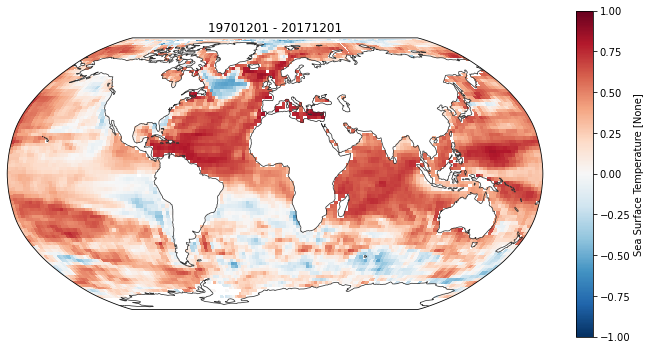

In [33]:
to_plot = skill[0]["sst"]

fig = plt.figure(figsize=(12, 6), edgecolor="k")
ax = fig.add_subplot(111, projection=ccrs.Robinson(0))

p = (
    to_plot.sel(skill="initialized")
    .isel(lead=1)
    .plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-1, vmax=1, cmap="RdBu_r")
)

p.axes.coastlines(color=[0.2, 0.2, 0.2], linewidth=0.75)
ax.set_title(f"{skill[0].attrs['verification period']}")

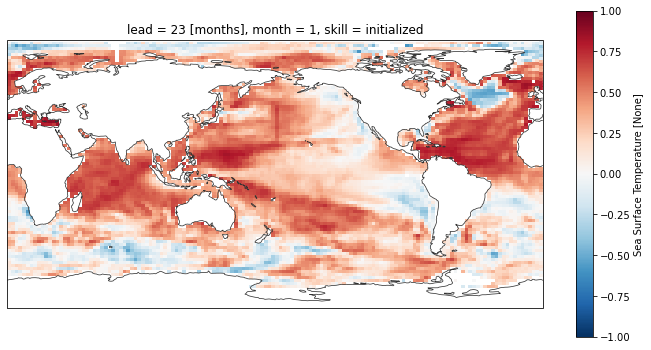

In [17]:
to_plot = skill[0]["sst"]

fig = plt.figure(figsize=(12, 6), edgecolor="k")
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))

p = (
    to_plot.sel(skill="initialized")
    .isel(lead=1)
    .plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-1, vmax=1, cmap="RdBu_r")
)

p.axes.coastlines(color=[0.2, 0.2, 0.2], linewidth=0.75)

In [29]:
a = xr.open_zarr("../../data/processed/CanESM5_hist.annual.anom_1991-2020.sst.zarr")

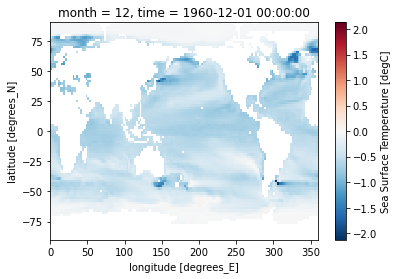

In [31]:
a["sst"].mean("member").isel(time=0).plot()